In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
### import some analysis functions we wrote for this project
import sys ; sys.path.append("../") ; sys.path.append("../../") 
from ppe_analysis.analysis import *
from pyfunctions import *

In [3]:
# Setup your PBSCluster
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='10GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    project='P93300641', # Input your project ID here
    walltime='2:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(10)

# Setup your client
client = Client(cluster)

In [ ]:
client.cluster

### Load data

In [4]:
#calculate SP LAI, by pft
dsp=xr.open_dataset('/glade/scratch/linnia/archive/LAI_SP_ctsm51d115/lnd/hist/LAI_SP_ctsm51d115.clm2.h1.2000-02-01-00000.nc')
dsp['time']=xr.cftime_range('2000',periods=12,freq='MS',calendar='noleap')
sg=xr.open_dataset('../clusters.clm51_PPEn02ctsm51d021_2deg_GSWP3V1_leafbiomassesai_PPE3_hist.annual+sd.400.nc')
la=sg.landfrac*sg.area

lai_sp=amax(dsp.TLAI).sel(year=2000)
w=dsp.pfts1d_wtgcell
laig=pftgrid(lai_sp,dsp)
wg=pftgrid(w,dsp)
cf=1/(wg*la).sum(dim=['lat','lon'])
laisp=cf*(laig*wg*la).sum(dim=['lat','lon']).sel(pft=range(0,16)).compute()

In [5]:
#get the pft names
pfts=xr.open_dataset('/glade/campaign/asp/djk2120/PPEn11/paramfiles/OAAT0000.nc').pftname
pfts=[str(p)[2:-1].strip() for p in pfts.values][0:16]
n_pfts = len(pfts)

In [6]:
# get ppe params
ppe_params = pd.read_csv('ppe_params_8-25.csv', sep=',',index_col=0)
n_uparams = 20
n_pparams = 12

In [7]:
u_params     = ['FUN_fracfixers','KCN','a_fix','crit_dayl','d_max','fff','fstor2tran','grperc',
                'jmaxb0','jmaxb1','kcha','lmrha','lmrhd','nstem','q10_mr','soilpsi_off','sucsat_sf',
                'tpu25ratio','tpuse_sf','wc2wjb0']
pft_params   = ['froot_leaf','kmax','krmax','leaf_long','leafcn','lmr_intercept_atkin',
                'medlynslope','medlynintercept','psi50','slatop','stem_leaf','theta_cj']

In [8]:
#load sample
u_sample= np.loadtxt('/glade/work/linnia/CLM-PPE-LAI_tests/exp2_pftLAI/universal_sample_8-25.txt',delimiter=',')
n_usamp = len(u_sample)

pft_sample= np.loadtxt('/glade/work/linnia/CLM-PPE-LAI_tests/exp2_pftLAI/pft_sample_8-25.txt',delimiter=',')
n_psamp = len(pft_sample)

In [9]:
#load LAI predicted with emulators
PFT_pred_lai = np.load('/glade/work/linnia/CLM-PPE-LAI_tests/exp2_pftLAI/PFT_pred_8-25.npy')
# load fractional bias with respect to CLM-SP
in_data = np.load('/glade/work/linnia/CLM-PPE-LAI_tests/exp2_pftLAI/fractional_bias_8-25.npy')
fbias_lai = xr.DataArray(in_data, dims=('usamp', 'psamp', 'pft'))

### Identify passing universal parameter sets

In [17]:
# exclude broadleaf evergreen temperate shrub
pft_ids = [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14]
# Set PFT specific error
#pft_oerror = np.tile(0.01, 16)
pft_oerror = 0.01

# Create a boolean mask indicating which sets pass the conditions
passing_sets = np.abs(fbias_lai.sel(pft=pft_ids)) < pft_oerror

# Check if all PFTs within a set meet the conditions
universal_ix=[]
for u in range(n_usamp):
    tmp = passing_sets[u,:,:].any(dim='psamp')
    if tmp.all():
        universal_ix.append(u)

print("Number of Not Ruled Out Yet (NROY) universal sets:", len(universal_ix))

Number of Not Ruled Out Yet (NROY) universal sets: 1445


In [18]:
n_Unroy = len(universal_ix) # number of universal not ruled out yet sets
Unroy_psets = u_sample[universal_ix,:]
Unroy_fbias_lai = fbias_lai.isel(usamp=universal_ix)

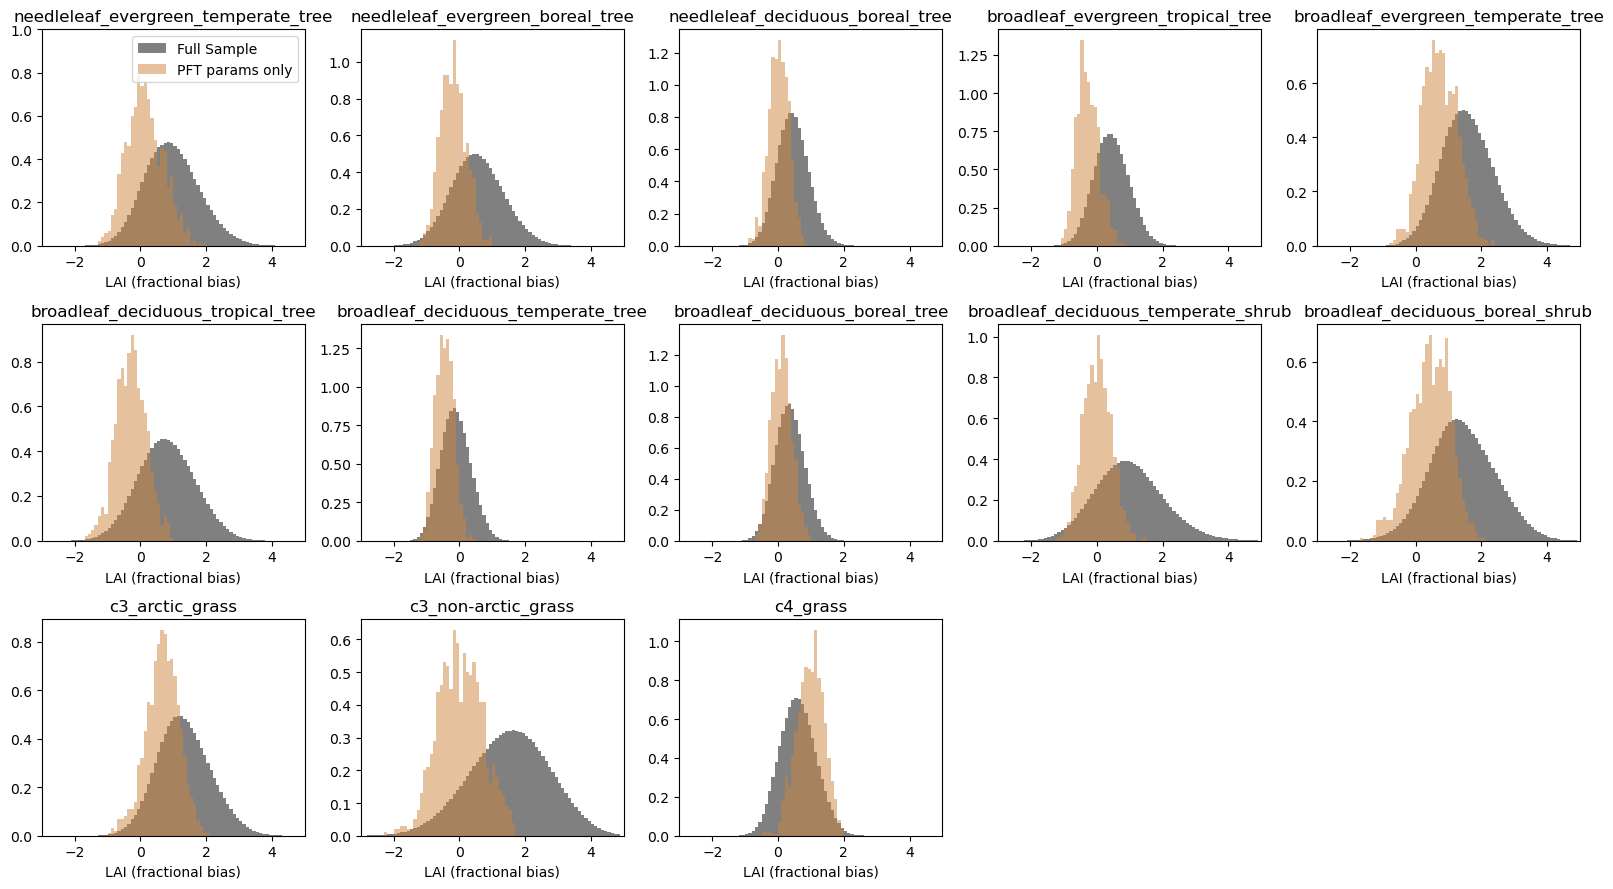

In [19]:
# plot fractional bias 
bins = np.arange(-3,5,0.1)

plt.figure(figsize=[16,9])
for i,p in enumerate(pft_ids):
    plt.subplot(3,5,i+1)
    plt.hist(fbias_lai.sel(pft=p).values.ravel(),bins=bins,density=True,color='grey',label='Full Sample')
    plt.hist(Unroy_fbias_lai.sel(usamp=1,pft=p).values.ravel(),bins=bins,density=True,color='peru',alpha=0.5,label='PFT params only')
    plt.title(pfts[p],fontsize=12)
    plt.xlim([-3,5])
    #plt.ylim([0,3500000])
    plt.xlabel('LAI (fractional bias)')
    if i==0:
        plt.legend()
        plt.ylim([0,1])
    
plt.tight_layout()
#plt.savefig('./figs/fbias_density_pft_uset0.png')

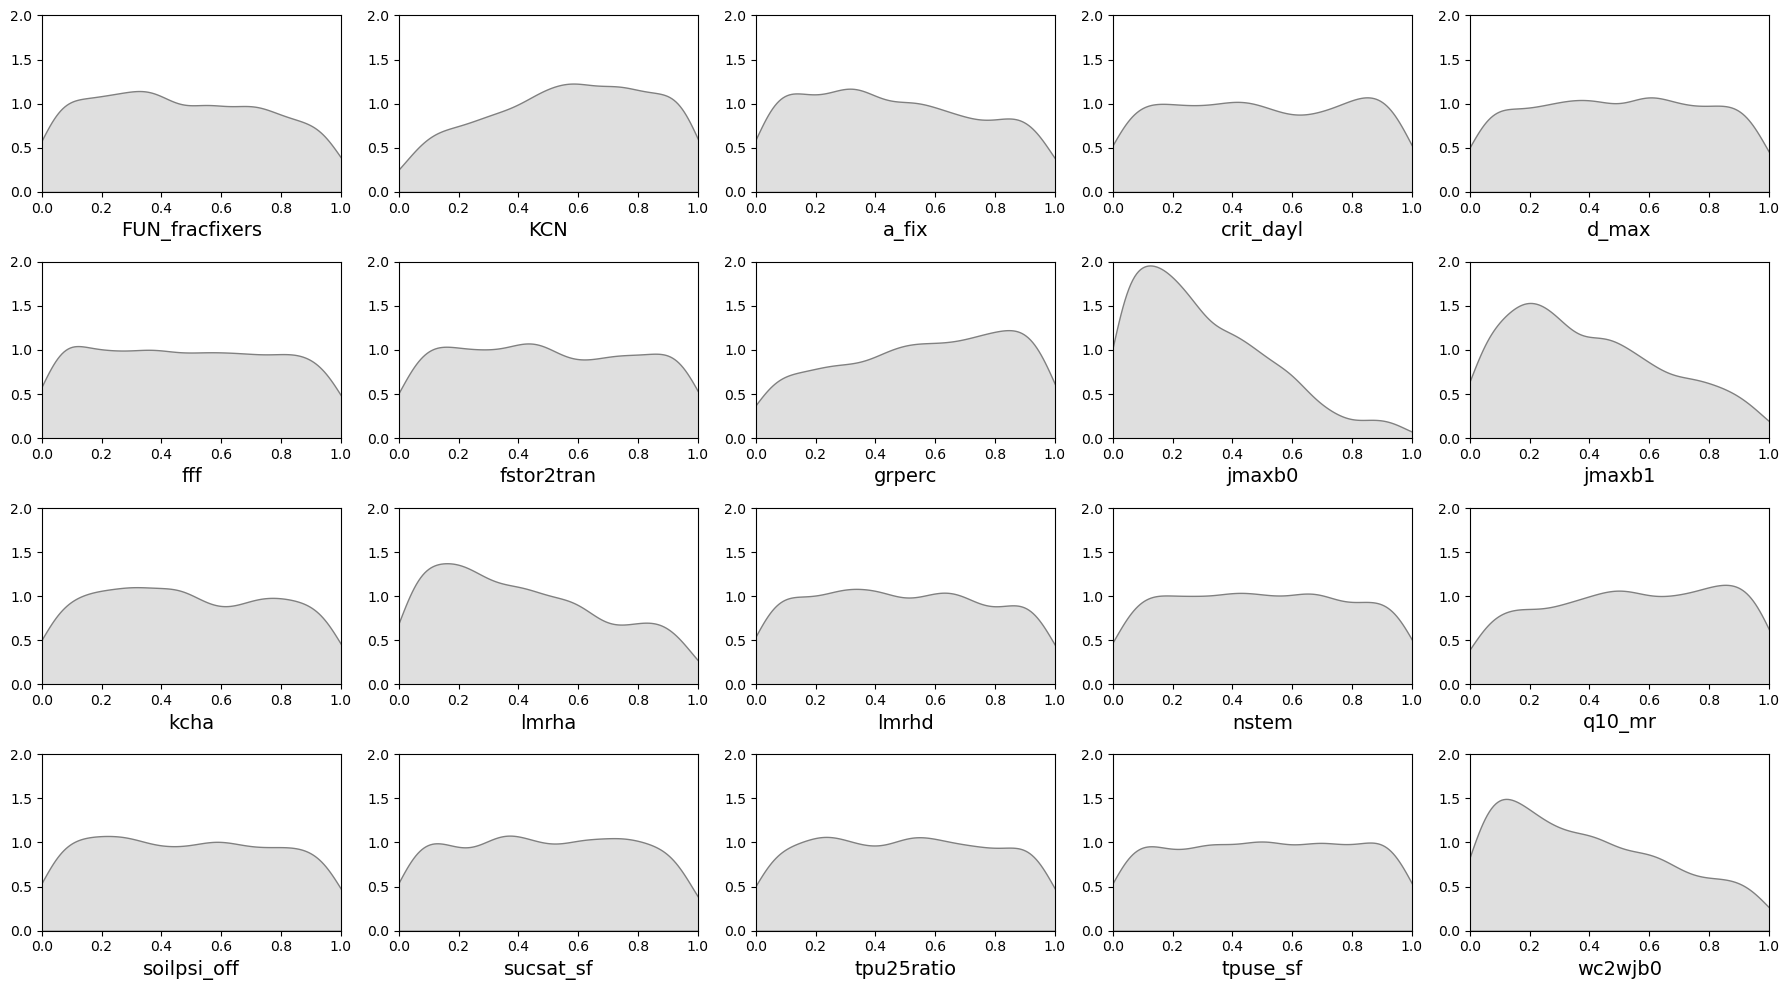

In [14]:
# plot distribution of universal parameter sets
df_Usets=pd.DataFrame(Unroy_psets,columns=ppe_params.columns[:len(u_params)])
plt.figure(figsize=[18,10])
for p in range(len(u_params)):
    plt.subplot(4,5,p+1)
    pname = df_Usets.columns[p]
    sns.distplot(df_Usets[pname], hist = False, kde = True,
                kde_kws = {'shade': True, 'linewidth': 1, "color":"grey"},
                label='')
    plt.xlim([0,1])
    plt.ylabel('')
    plt.xlabel(pname,fontsize=14)
    plt.ylim([0,2])
    #plt.legend()
plt.tight_layout()
#plt.savefig('./figs/Usets_dist_SPtarget.png')

### Rule out PFT psets for each Universal pset

In [20]:
# For each passing Universal set, which PFTsets are within observational tolerance?

pft_ix_mask = np.empty((n_Unroy,n_psamp,16))*np.NaN   
Pnroy_psets = np.empty((n_Unroy,n_psamp,n_pparams,16))*np.NaN

for u in range(n_Unroy):
    for p in pft_ids:
        tmp = np.abs(Unroy_fbias_lai.isel(usamp=u,pft=p))< pft_oerror #pft_oerror[p]
        pft_ix_mask[u,:,p] = tmp
        psamp_ix = np.where(tmp)[0]
        Pnroy_psets[u,0:len(psamp_ix),:,p] = pft_sample[psamp_ix,:]

pft_ix_mask[pft_ix_mask==0] = np.NaN   

In [21]:
nroy_fbias_lai = Unroy_fbias_lai*pft_ix_mask

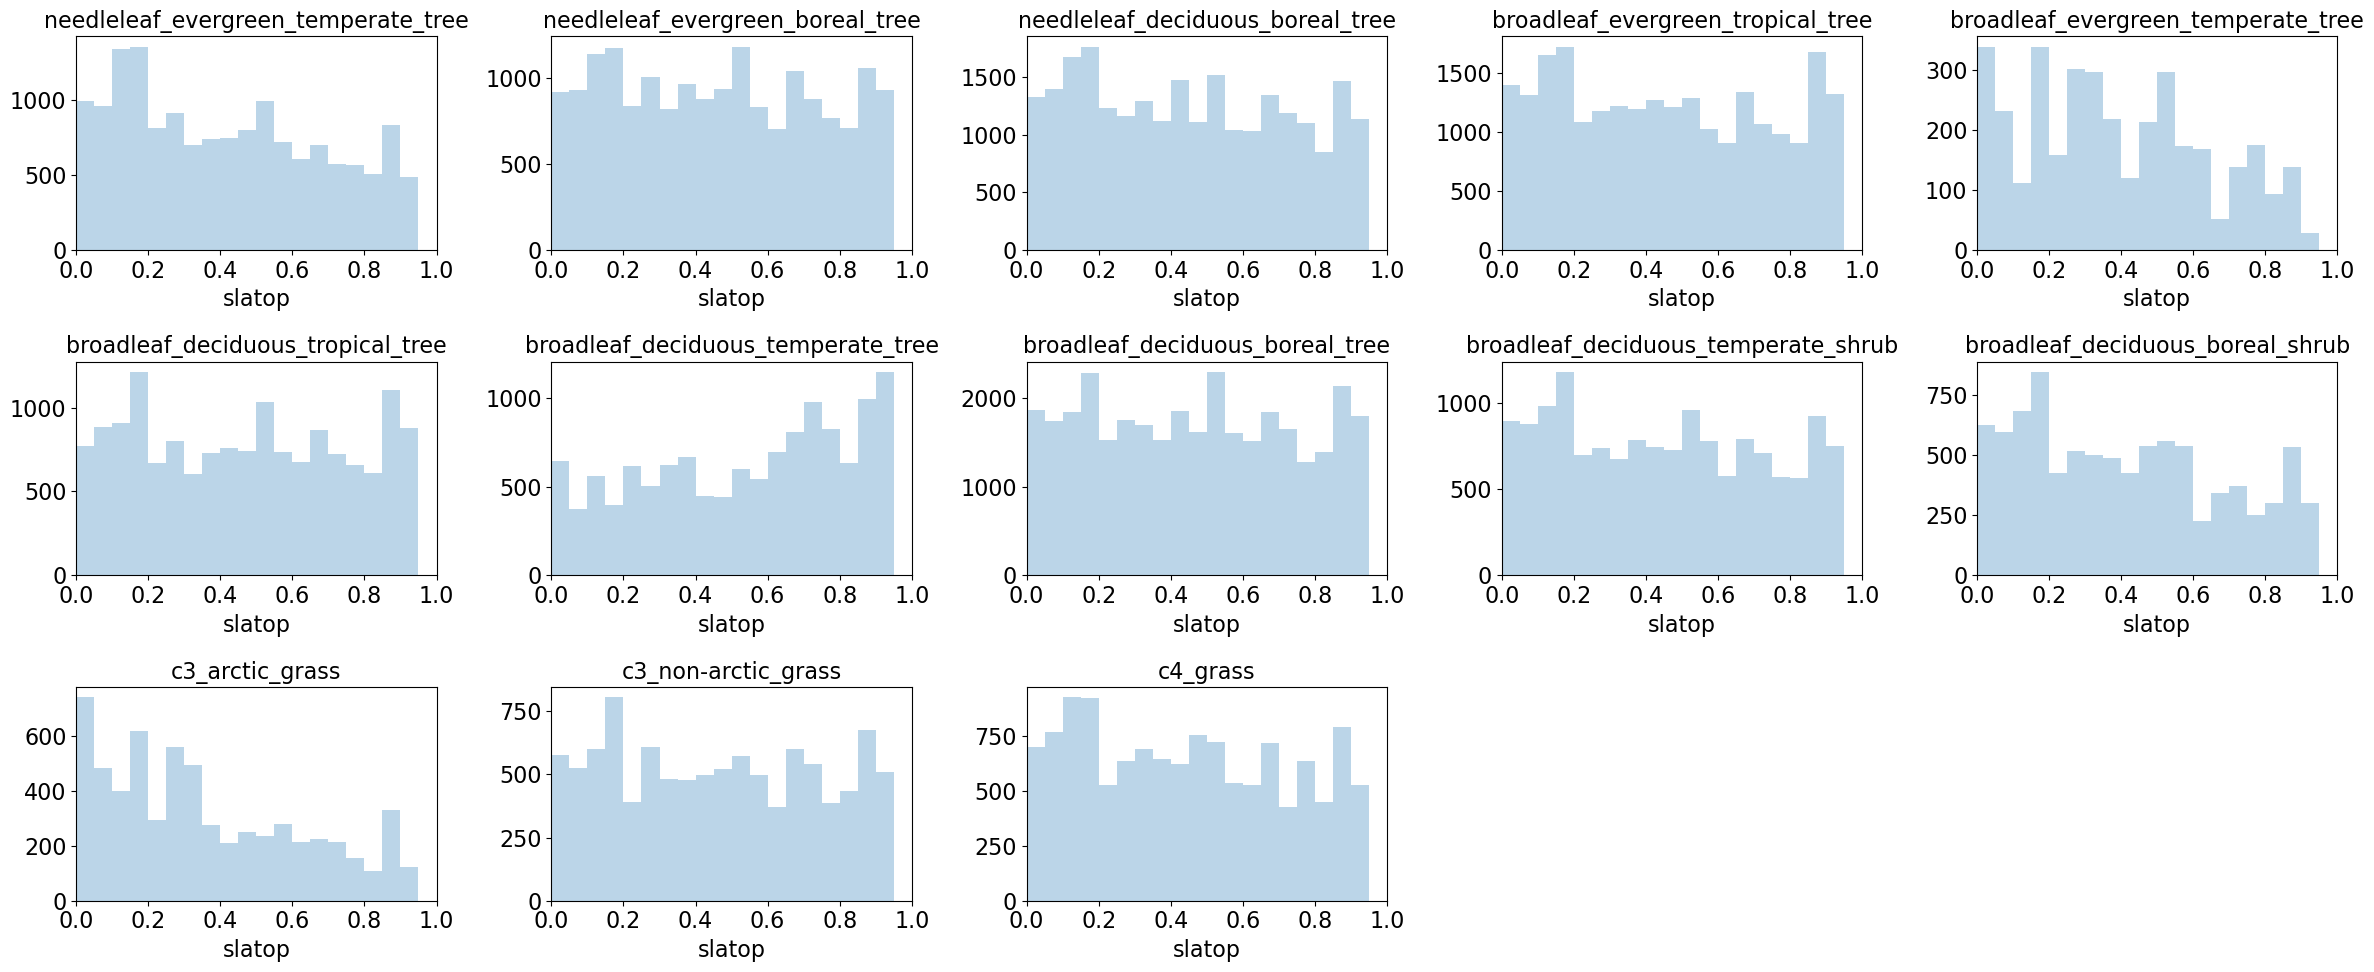

In [22]:
plt.figure(figsize=[24,10])
plt.rcParams.update({'font.size': 16})
bins = np.arange(0,1,0.05)
i=1
for p in pft_ids:
    plt.subplot(3,5,i)
    plt.hist(Pnroy_psets[:,:,9,p].flatten(),bins = bins,alpha=0.3)
    plt.title(pfts[p],fontsize=16)
    plt.xlim([0,1])
    plt.xlabel('slatop')
    i = i+1
plt.tight_layout()
plt.savefig('./figs/slatop_all.png')

### Randomly select from NROY sets

In [22]:
nsets = 25
rand_uset_ix = np.random.randint(0, n_Unroy, size=nsets, dtype='l')
rand_usets = Unroy_psets[rand_uset_ix,:]

In [23]:
np.shape(rand_usets)

(25, 20)

In [24]:
rand_uset_ix

array([1200,  964,  570,  117, 1050,  880, 1378,   48,  343,  414,  456,
       1272,  932, 1074,  292,  245,    6,  691,   23,  177,  839,  716,
        935,   28,  211])

In [25]:
rand_psets = np.ones([nsets,79,12])*0.5
for i,u in enumerate(rand_uset_ix):
    for p in pft_ids:
        var = pft_ix_mask[u,:,p]
        ids = np.where(~np.isnan(var))
        rand_pset_ix = np.random.choice(ids[0],1)
        rand_psets[i,p,:] = pft_sample[rand_pset_ix,:]

#### Write parameter sets

In [83]:
keys = ppe_params.columns
pset_dict = {}

In [84]:
for u in range(len(u_params)):
    pset_dict[keys[u]] = rand_usets[:,u]
for i,p in enumerate(pft_params):
    pset_dict[p] = rand_psets[:,:,i]

In [85]:
pset_dict[pset_dict==np.nan] = 0.5

In [86]:
extra_pfts = [0,9,15,16]
for i in range(25):
    pset_dict['medlynintercept'][i][extra_pfts]= 0.08
    pset_dict['theta_cj'][i][extra_pfts]=0.9

In [88]:
pset_dict['theta_cj'][0:5]

array([[0.9       , 0.36055408, 0.7142911 , 0.68761179, 0.92637338,
        0.34110051, 0.76359755, 0.90663418, 0.24507713, 0.9       ,
        0.12691972, 0.02604925, 0.99849368, 0.14512763, 0.24575659,
        0.9       , 0.9       , 0.5       , 0.5       , 0.5       ,
        0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
        0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
        0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
        0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
        0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
        0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
        0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
        0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
        0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
        0.5       , 0.5       , 0.5       , 0.5       , 0.5       ,
        0.5       , 0.5       , 0.5       , 0.5 

In [89]:
np.save('pftLAI_psets_8-25.npy', pset_dict)

### Sanity Check! Load emulators and check all Psets and PFTs

In [10]:
fav_sets = np.load('pftLAI_psets_8-25.npy',allow_pickle=True).item()

In [11]:
fav_sets_r = np.empty((25,32,16))*np.NaN

for pft in range(1,15):
    for u in range(25):
        a=[] ; b=[]
        for i,up in enumerate(u_params):
            a.append(fav_sets[up][u])
        for i,pp in enumerate(pft_params):
            b.append(fav_sets[pp][u][pft])
        fav_sets_r[u,:,pft] = np.hstack([a,b])

In [20]:
# Check if loaded emulator gives identical predicted PFT LAI for sub-sample
import tensorflow as tf
from emulation_pyfunctions import *

p=1
s = fav_sets_r[:,:,p]
loaded_emulator = tf.saved_model.load('./models/needleleaf_evergreen_temperate_tree/')
y_pred_st, _ = loaded_emulator.compiled_predict_y(s) 

2023-08-30 15:30:47.577015: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-30 15:30:47.747863: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-30 15:30:47.792533: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-08-30 15:30:49.336930: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [21]:
y_pred_st

<tf.Tensor: shape=(25, 1), dtype=float64, numpy=
array([[-1.13144049],
       [-1.12248172],
       [-1.13827764],
       [-1.12604451],
       [-1.12356794],
       [-1.12108563],
       [-1.11986288],
       [-1.13183328],
       [-1.12042984],
       [-1.12143113],
       [-1.12508399],
       [-1.12985689],
       [-1.1307137 ],
       [-1.12798194],
       [-1.13768537],
       [-1.13701579],
       [-1.12087779],
       [-1.13110206],
       [-1.12161865],
       [-1.11991524],
       [-1.13172037],
       [-1.13261099],
       [-1.12478833],
       [-1.12839757],
       [-1.11992694]])>

In [12]:
# CLM-PPE
dvs=['TLAI','GPP']
htape='h1'
yr0=2003
yr1=2014
ds=get_exp('transient',dvs=dvs,tape=htape,yy=(yr0,yr1))

In [13]:
t=slice(str(yr0),str(yr1))
da=ds.TLAI.sel(time=t)
la=xr.open_dataset('landarea_transient.nc').landarea_pft.sel(time=t)
amax_lai=amax(da).mean(dim='year').compute()
PPE_lai = pmean(amax_lai,la).mean(dim='time').compute()

In [14]:
t=slice(str(yr0),str(yr1))
da=ds.GPP.sel(time=t)
la=xr.open_dataset('landarea_transient.nc').landarea_pft.sel(time=t)
amax_gpp=amax(da).mean(dim='year').compute()
PPE_gpp = pmean(amax_gpp,la).mean(dim='time').compute()

In [24]:
laisp

<xarray.DataArray (pft: 16)>
array([       nan, 3.53179783, 2.91895973, 3.11051743, 4.93175992,
       3.59305257, 2.76815674, 3.30504625, 3.17454784, 0.53734455,
       0.54247099, 1.17644415, 1.00819218, 1.27039161, 1.52417235,
       2.19848416])
Coordinates:
  * pft      (pft) float64 0.0 1.0 2.0 3.0 4.0 5.0 ... 11.0 12.0 13.0 14.0 15.0

In [25]:
y_pred_check = unstandardize(np.array(y_pred_st).reshape(1,-1),PPE_lai.sel(pft=p))
y_pred_check

array([[3.53008403, 3.55706094, 3.50949581, 3.54633258, 3.55379008,
        3.56126489, 3.56494686, 3.52890127, 3.56323961, 3.5602245 ,
        3.54922492, 3.53485262, 3.53227257, 3.54049853, 3.51127927,
        3.51329553, 3.56189072, 3.53110314, 3.55965983, 3.5647892 ,
        3.52924124, 3.5265594 , 3.55011522, 3.53924698, 3.56475397]])

### Pick my favorites

In [43]:
#load PFT_pred_gpp
PFT_pred_gpp = np.load('/glade/work/linnia/CLM-PPE-LAI_tests/exp2_pftLAI/PFT_pred_GPP_8-25.npy')
#load bias relative to default CLM model
#fbias_gpp = np.load('/glade/work/linnia/CLM-PPE-LAI_tests/exp2_pftLAI/fractional_bias_gpp_8-25.npy')

In [ ]:
fbias_gpp_usets = fbias_gpp[usets_ix,:,:]
fbias_gpp_usets = fbias_gpp_usets[:,:,pft_ids]
fbias_gpp_in = fbias_gpp_usets*PFT_mask

In [ ]:
# Select sets with c4 grass gpp ~50% lower
p=12
in_var = fbias_gpp_in[:,:,p]
tmp = np.abs(in_var+0.5)<0.05

In [25]:
c4_usets = np.where(tmp)[0]

In [26]:
### ID Usets with Bleaf evergreen tropical tree GPP (200% increase)
p=3
in_var = fbias_gpp_in[:,:,p]
tmp = np.abs(in_var)<0.05
bt_usets = np.where(tmp)[0]

In [27]:
fav_usets = np.intersect1d(c4_usets, bt_usets)

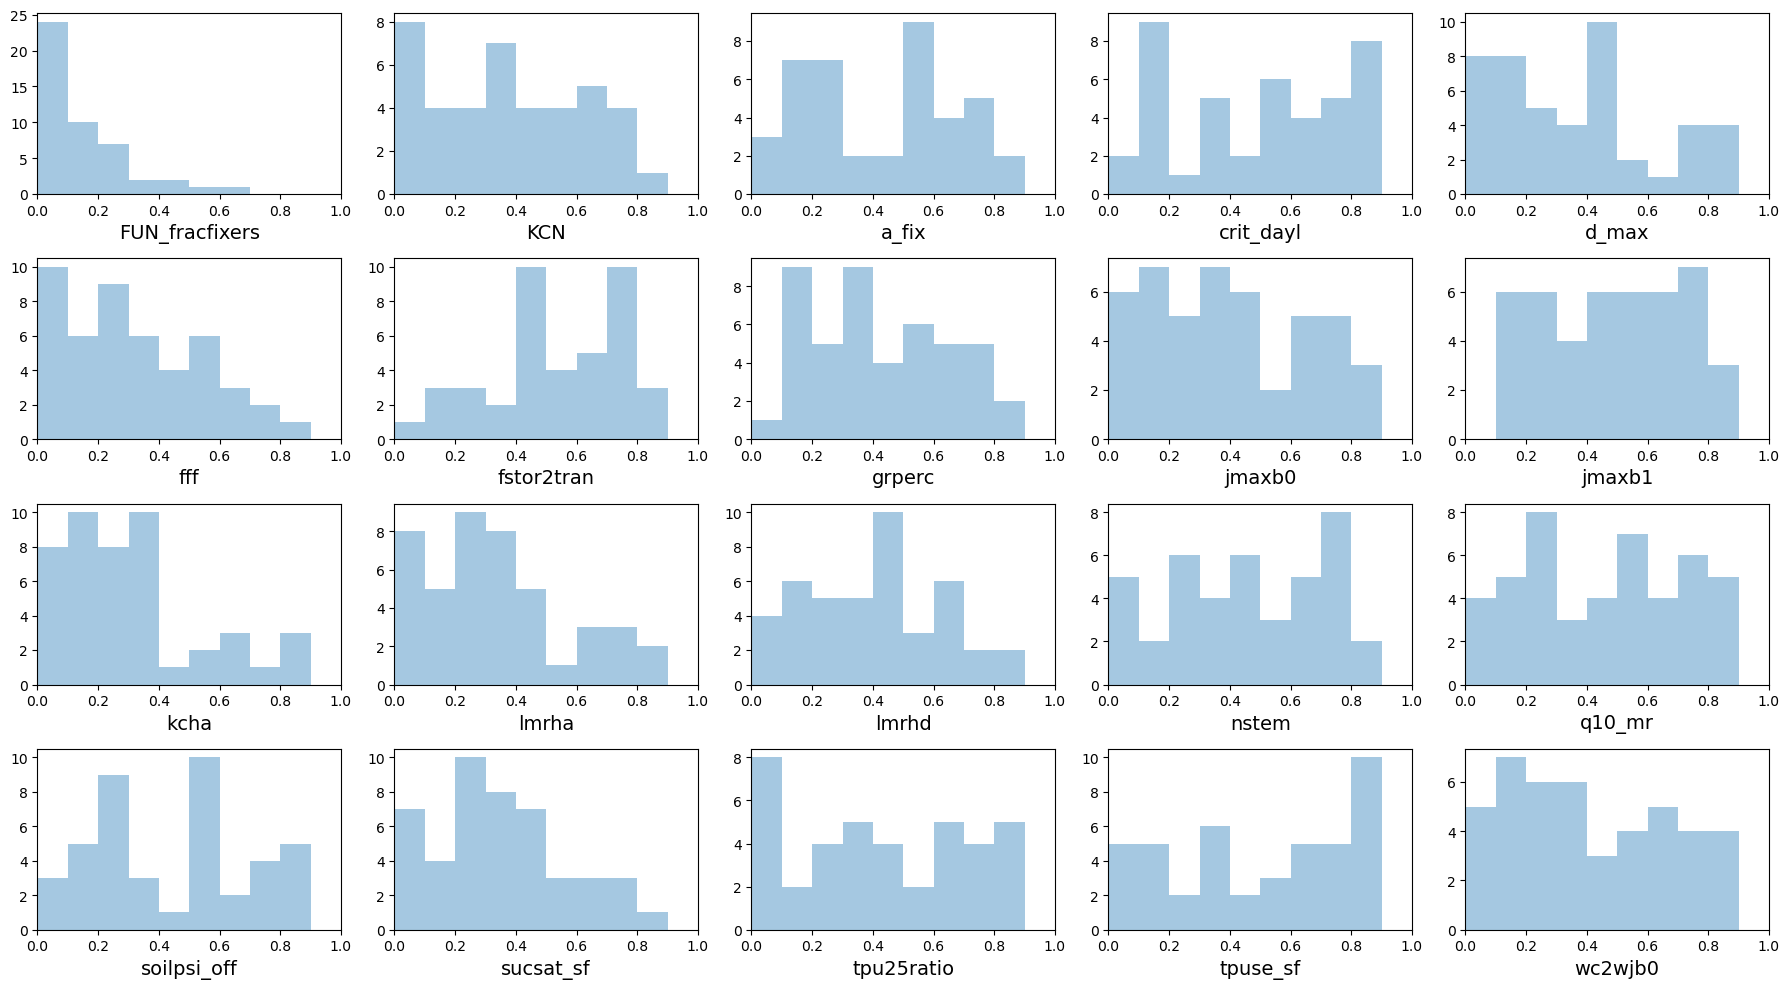

In [29]:
# where are they in parameter space?
selected_usets = Upsets[fav_usets,:]
# plot distribution of universal parameter sets
bins = np.arange(0,1,0.1)
df_Usets=pd.DataFrame(selected_usets,columns=ppe_params.columns[:len(u_params)])
plt.figure(figsize=[18,10])
for p in range(len(u_params)):
    plt.subplot(4,5,p+1)
    pname = df_Usets.columns[p]
    sns.distplot(df_Usets[pname], bins=bins, hist = True, kde = False,
                #kde_kws = {'shade': True, 'linewidth': 1, "color":"grey"},
                label='')
    plt.xlim([0,1])
    plt.ylabel('')
    plt.xlabel(pname,fontsize=14)
    #plt.ylim([0,2])
    #plt.legend()
plt.tight_layout()
#plt.savefig('./figs/Usets_dist_SPtarget.png')

In [32]:
# For this Universal parameter set, which PFT specific parameter sets minimize LAI and GPP error in each PFT? 
sel_uset_ix = fav_usets[7]

pftset_ix=np.empty(13)*np.nan
# for PFTs where we want to minimize GPP:
for p in  [0,1,2,7,8,9,10,11,12]: 
    in_var = np.abs(fbias_gpp_in[sel_uset_ix,:,p])
    pftset_ix[p] = np.nanargmin(in_var)
    
# for PFTs where we want to maximize GPP:
for p in [3,4,5,6]: 
    in_var = np.abs(fbias_gpp_in[sel_uset_ix,:,p])
    pftset_ix[p] = np.nanargmin(in_var)

    #Ones that don't matter: 4,6,8,

In [33]:
pftset_ix.astype('int')

array([739, 525, 226, 397, 118, 831, 340, 379, 383, 779, 270, 175, 239])

In [34]:
ppe_params.columns

Index(['FUN_fracfixers', 'KCN', 'a_fix', 'crit_dayl', 'd_max', 'fff',
       'fstor2tran', 'grperc', 'jmaxb0', 'jmaxb1', 'kcha', 'lmrha', 'lmrhd',
       'nstem', 'q10_mr', 'soilpsi_off', 'sucsat_sf', 'tpu25ratio', 'tpuse_sf',
       'wc2wjb0', 'froot_leaf', 'kmax', 'krmax', 'leaf_long', 'leafcn',
       'lmr_intercept_atkin', 'medlynslope', 'medlynintercept', 'psi50',
       'slatop', 'stem_leaf', 'theta_cj'],
      dtype='object')

In [35]:
fav_PFT_sets = pd.DataFrame(pft_sample[pftset_ix.astype('int'),:])
#fav_PFT_sets.columns = ppe_params.columns
fav_PFT_sets

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.319483,0.397509,0.123914,0.168898,0.829204,0.620094,0.611438,0.402864,0.786497,0.648430,0.725809,0.022029
1,0.027557,0.009340,0.121935,0.237708,0.142868,0.861708,0.175771,0.763248,0.980250,0.272295,0.079202,0.133636
2,0.050062,0.983527,0.679284,0.778805,0.050132,0.205059,0.566773,0.700269,0.078406,0.516181,0.686625,0.017910
3,0.581628,0.299152,0.240880,0.441137,0.852317,0.297975,0.791445,0.594475,0.262783,0.915483,0.619374,0.429721
4,0.637118,0.407327,0.727249,0.132471,0.961972,0.233771,0.193821,0.237414,0.143169,0.337080,0.828704,0.144718
5,0.740279,0.124390,0.452949,0.469274,0.902969,0.385238,0.299869,0.520458,0.994716,0.861385,0.597359,0.293206
6,0.040486,0.172489,0.993603,0.120022,0.046570,0.864202,0.346911,0.978197,0.946996,0.867553,0.247520,0.719984
7,0.756796,0.402818,0.807494,0.572681,0.242175,0.178396,0.317831,0.916283,0.449119,0.262810,0.499593,0.985005
8,0.833570,0.377230,0.862372,0.075041,0.005676,0.405869,0.161333,0.504817,0.977265,0.234668,0.943613,0.876352
9,0.410897,0.342291,0.335527,0.976412,0.115526,0.642745,0.003515,0.554104,0.786203,0.391577,0.063040,0.574655


In [36]:
pfts

['not_vegetated',
 'needleleaf_evergreen_temperate_tree',
 'needleleaf_evergreen_boreal_tree',
 'needleleaf_deciduous_boreal_tree',
 'broadleaf_evergreen_tropical_tree',
 'broadleaf_evergreen_temperate_tree',
 'broadleaf_deciduous_tropical_tree',
 'broadleaf_deciduous_temperate_tree',
 'broadleaf_deciduous_boreal_tree',
 'broadleaf_evergreen_shrub',
 'broadleaf_deciduous_temperate_shrub',
 'broadleaf_deciduous_boreal_shrub',
 'c3_arctic_grass',
 'c3_non-arctic_grass',
 'c4_grass',
 'c3_crop']

### Plot History Matching

In [15]:
t=slice(str(2003),str(2014))
la=xr.open_dataset('landarea_transient.nc').landarea_pft.sel(time=t).mean(dim='time')

In [26]:
PFT_pred_lai = PFT_pred_lai[:,:,pft_ids]
tmp = PFT_pred_lai[universal_ix,:,:]
pred_lai_in = tmp*pft_ix_mask[:,:,pft_ids]

In [74]:
PFT_pred_gpp = PFT_pred_gpp[:,:,pft_ids]

In [152]:
# scale GPP
p=1
scaler=1e-9*365*24*60*60*la.sel(pft=p).sum()/100
GPP_var = PFT_pred_gpp*scaler.values

pred_gpp_usets = PFT_pred_gpp[universal_ix,:,:]*scaler.values
pred_gpp_in = pred_gpp_usets*pft_ix_mask[:,:,pft_ids]

PPE_gpp_pft = PPE_gpp.sel(pft=p)*scaler.values

plotting


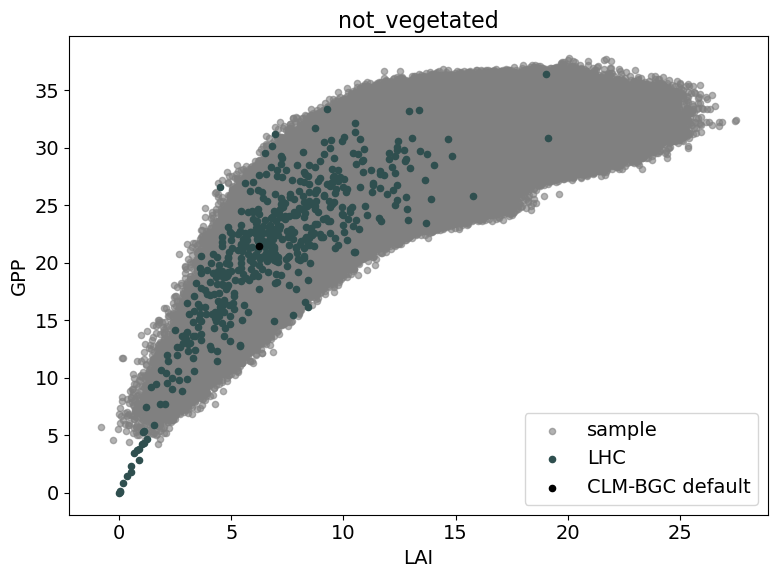

In [155]:
# plot fractional bias LAI v GPP
plt.figure(figsize=[8,6])
plt.rcParams.update({'font.size': 14})
p=1
i=0

x = xr.DataArray(5+PFT_pred_lai[:,:,i].flatten())
y = xr.DataArray(15+GPP_var[:,:,i].flatten())
plt.scatter(x,y,s=20,color='grey',alpha=0.6,label='sample')
plt.scatter(PPE_lai.sel(pft=p),PPE_gpp_pft,s=20,color='darkslategrey',label='LHC')
plt.scatter(PPE_lai.sel(ens=0,pft=p),PPE_gpp_pft.isel(ens=0),s=20,color='k',label='CLM-BGC default')
print('plotting')
#plt.scatter(PFT_pred_lai[universal_ix,:,i].flatten(),pred_gpp_usets[:,:,i].flatten(),s=10,color='peru',alpha = 0.8,label='universal sets')
#plt.scatter(pred_lai_in[:,:,i].flatten(),pred_gpp_in[:,:,i].flatten(),s=10,color='darkgrey',label='pft sets')
#plt.scatter(pred_lai_in[pftset_ix.astype('int'),1,i].flatten(),pred_gpp_in[pftset_ix.astype('int'),1,i].flatten(),s=10,color='darkgreen',label='final sets')
#sets = pft_lai_ix[:,:,i]
#lai_var = fbias_usets[:,:,i]
#gpp_var = fbias_gpp_usets[:,:,i]
#plt.scatter(lai_var[sets].flatten(),gpp_var[sets].flatten(),color='green')

plt.xlabel('LAI')
plt.ylabel('GPP')
plt.title(pfts[i],fontsize=16)
#plt.xlim([0,30])
#plt.ylim([0,50])
plt.legend(loc='lower right')
    
plt.tight_layout()
#plt.savefig('./figs/NET_temp_scatter_demo_2.png',dpi=100)

In [33]:
laisp

<xarray.DataArray (pft: 16)>
array([       nan, 3.53179783, 2.91895973, 3.11051743, 4.93175992,
       3.59305257, 2.76815674, 3.30504625, 3.17454784, 0.53734455,
       0.54247099, 1.17644415, 1.00819218, 1.27039161, 1.52417235,
       2.19848416])
Coordinates:
  * pft      (pft) float64 0.0 1.0 2.0 3.0 4.0 5.0 ... 11.0 12.0 13.0 14.0 15.0

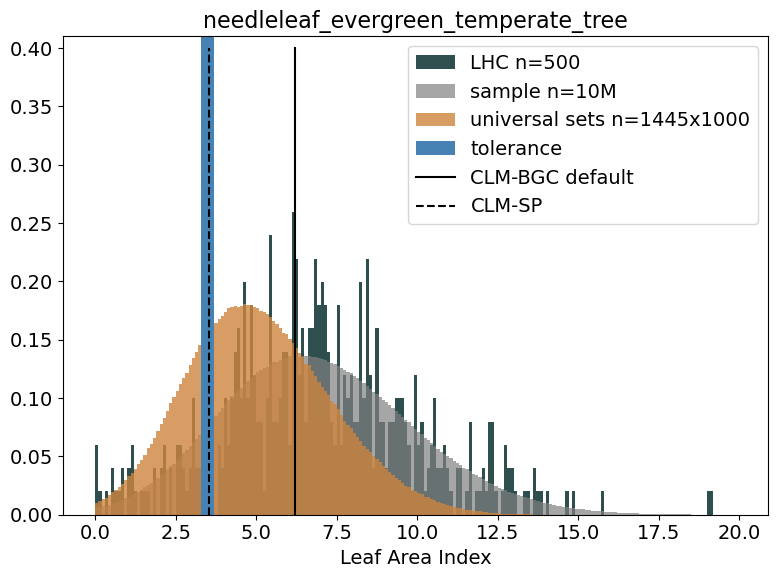

In [65]:
# plot fractional bias LAI v GPP
plt.figure(figsize=[8,6])
plt.rcParams.update({'font.size': 14})
bins = np.arange(0,20,0.1)
bins2 = np.arange(3.50,3.55,0.0001)
p=1
i=0
x = xr.DataArray(PFT_pred_lai[:,:,i].flatten())

plt.hist(PPE_lai.sel(pft=p).values,bins=bins,color='darkslategrey',alpha=1,label='LHC n=500',density=True)
plt.hist(x,bins=bins,color='grey',alpha=0.7,label='sample n=10M',density=True)
plt.hist(PFT_pred_lai[universal_ix,:,i].flatten(),bins=bins,color='peru',alpha = 0.8,label='universal sets n=1445x1000',density=True)
#plt.hist(pred_lai_in[1,:,i].flatten(),bins=bins2,color='green',label='pft sets',density=True)
plt.hist(tmp2[0:10],bins=bins,color='steelblue',label='tolerance',density=True)


plt.plot([PPE_lai.sel(ens=0,pft=p).values,PPE_lai.sel(ens=0,pft=p).values],[0,0.4],color='k',label='CLM-BGC default')
plt.plot([laisp[1],laisp[1]],[0,0.4],color='k',linestyle='--',label='CLM-SP')

#plt.scatter(pred_lai_in[pftset_ix.astype('int'),1,i].flatten(),pred_gpp_in[pftset_ix.astype('int'),1,i].flatten(),s=10,color='darkgreen',label='final sets')
#sets = pft_lai_ix[:,:,i]
#lai_var = fbias_usets[:,:,i]
#gpp_var = fbias_gpp_usets[:,:,i]
#plt.scatter(lai_var[sets].flatten(),gpp_var[sets].flatten(),color='green')

plt.xlabel('Leaf Area Index')
plt.title(pfts[p],fontsize=16)
#plt.xlim([0,30])
plt.ylim([0,0.41])
plt.legend(loc='upper right')
    
plt.tight_layout()
plt.savefig('./figs/NET_temp_scatter_demo_4.png',dpi=100)

In [60]:
tmp = PFT_pred_lai[universal_ix,:,i]
tmp1 = tmp[tmp<3.75]
tmp2 = tmp1[tmp1>3.36]
np.shape(tmp2)

(88333,)

### Write PFT sets

In [148]:
sel_uset = np.tile(Upsets[sel_uset_ix,:],len(pftset_ix))
df_uset = pd.DataFrame(sel_uset.reshape(len(pftset_ix),20))
df_uset.columns=ppe_params.columns[:len(u_params)]
df_uset

,FUN_fracfixers,KCN,a_fix,crit_dayl,d_max,fff,fstor2tran,grperc,jmaxb0,jmaxb1,kcha,lmrha,lmrhd,nstem,q10_mr,soilpsi_off,sucsat_sf,tpu25ratio,tpuse_sf,wc2wjb0
0,0.285382,0.04309,0.169808,0.130834,0.232183,0.578289,0.630116,0.838424,0.600293,0.644045,0.441766,0.077013,0.223695,0.699055,0.862042,0.599532,0.265489,0.079913,0.163175,0.638546
1,0.285382,0.04309,0.169808,0.130834,0.232183,0.578289,0.630116,0.838424,0.600293,0.644045,0.441766,0.077013,0.223695,0.699055,0.862042,0.599532,0.265489,0.079913,0.163175,0.638546
2,0.285382,0.04309,0.169808,0.130834,0.232183,0.578289,0.630116,0.838424,0.600293,0.644045,0.441766,0.077013,0.223695,0.699055,0.862042,0.599532,0.265489,0.079913,0.163175,0.638546
3,0.285382,0.04309,0.169808,0.130834,0.232183,0.578289,0.630116,0.838424,0.600293,0.644045,0.441766,0.077013,0.223695,0.699055,0.862042,0.599532,0.265489,0.079913,0.163175,0.638546
4,0.285382,0.04309,0.169808,0.130834,0.232183,0.578289,0.630116,0.838424,0.600293,0.644045,0.441766,0.077013,0.223695,0.699055,0.862042,0.599532,0.265489,0.079913,0.163175,0.638546
5,0.285382,0.04309,0.169808,0.130834,0.232183,0.578289,0.630116,0.838424,0.600293,0.644045,0.441766,0.077013,0.223695,0.699055,0.862042,0.599532,0.265489,0.079913,0.163175,0.638546
6,0.285382,0.04309,0.169808,0.130834,0.232183,0.578289,0.630116,0.838424,0.600293,0.644045,0.441766,0.077013,0.223695,0.699055,0.862042,0.599532,0.265489,0.079913,0.163175,0.638546
7,0.285382,0.04309,0.169808,0.130834,0.232183,0.578289,0.630116,0.838424,0.600293,0.644045,0.441766,0.077013,0.223695,0.699055,0.862042,0.599532,0.265489,0.079913,0.163175,0.638546
8,0.285382,0.04309,0.169808,0.130834,0.232183,0.578289,0.630116,0.838424,0.600293,0.644045,0.441766,0.077013,0.223695,0.699055,0.862042,0.599532,0.265489,0.079913,0.163175,0.638546
9,0.285382,0.04309,0.169808,0.130834,0.232183,0.578289,0.630116,0.838424,0.600293,0.644045,0.441766,0.077013,0.223695,0.699055,0.862042,0.599532,0.265489,0.079913,0.163175,0.638546


In [131]:
# Each row is a PFT parameter set for a different PFT
for p in range(13):
    sel_pft_sets = pft_sample[pftset_ix[i].astype(int),:]
    # then append this list to the sel_uset list somehow. 

# save a stack of mis-shaped lists


In [132]:
sel_pft_sets

array([0.54443649, 0.82811856, 0.13647765, 0.96791954, 0.84077395,
       0.86525621, 0.2993194 , 0.50116632, 0.17355487, 0.41753674,
       0.8097701 , 0.70514073])